In [ ]:
%matplotlib inline

import os
import numpy as np
import cv2
import torch

from generic_pose.eval.pose_grid_estimator import PoseGridEstimator
from generic_pose.models.pose_networks import gen_pose_net, load_state_dict

from generic_pose.utils import to_np
from generic_pose.utils.image_preprocessing import cropBBox, seg2Mask, unprocessImages
from generic_pose.eval.template_pose_estimator import computeT 
from pycocotools.coco import COCO
import imantics

import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = 20, 12

In [5]:
def imshowCV(img, axis = False):
    if not axis:
        plt.axis('off')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [6]:
annotation_path = '/home/bokorn/data/surgical/images/coco/annotations/instances_train2014.json'
image_path = '/home/bokorn/data/surgical/images/coco/coco_train2014/'

weight_file = '/home/bokorn/data/surgical/weights/hemostat_black/weights.pth'
render_folder = '/home/bokorn/data/surgical/weights/hemostat_black/'
object_model = '/home/bokorn/data/surgical/models/hemostat/hemostat_black.obj'
category_name = 'hemostat'
f = 570.3422241210938
p = (319.5, 238.5)
idx = 10

In [7]:
coco = COCO(annotation_path)
cat_ids = coco.getCatIds(catNms=[category_name])
cats = coco.loadCats(cat_ids)
img_ids = coco.getImgIds(catIds=cat_ids)
ann_ids =  coco.getAnnIds(catIds=cat_ids)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


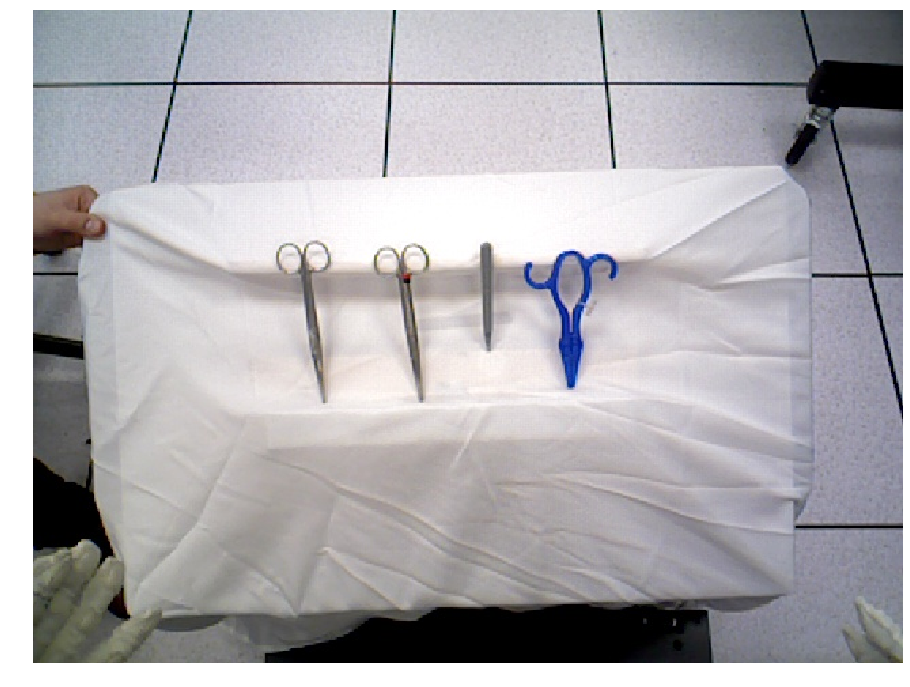

In [8]:
ann_info = coco.loadAnns(ann_ids[idx])[0]
img_info = coco.loadImgs(ann_info['image_id'])[0]
img = cv2.imread(os.path.join(image_path, img_info['file_name']))
imshowCV(img)

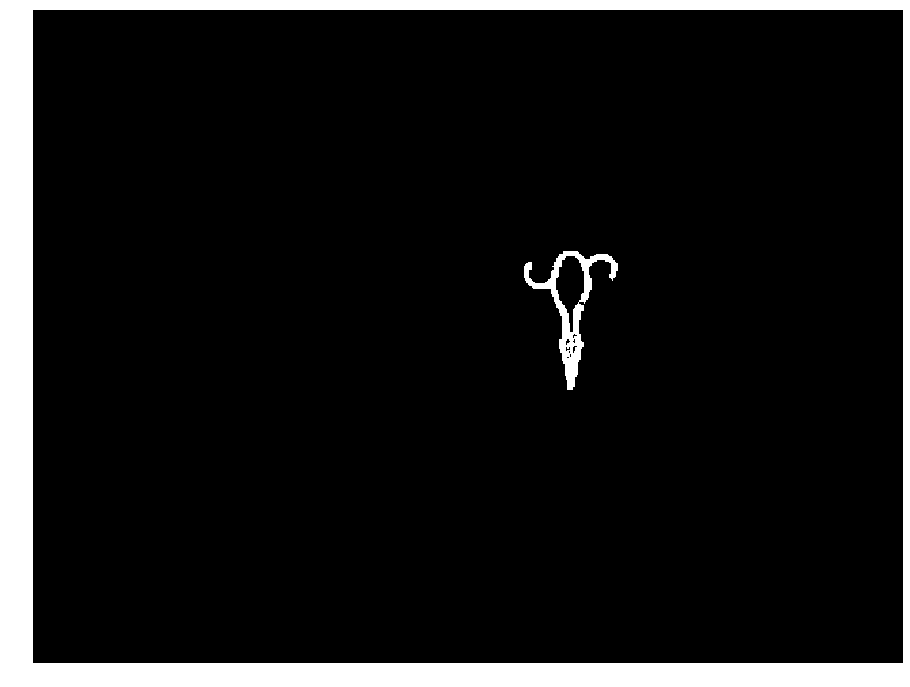

In [9]:
disp_img = img.copy()
mask = seg2Mask(ann_info['segmentation'], img.shape)
disp_mask = np.concatenate([255*mask.astype(np.uint8),]*3, axis=2)
imshowCV(disp_mask)


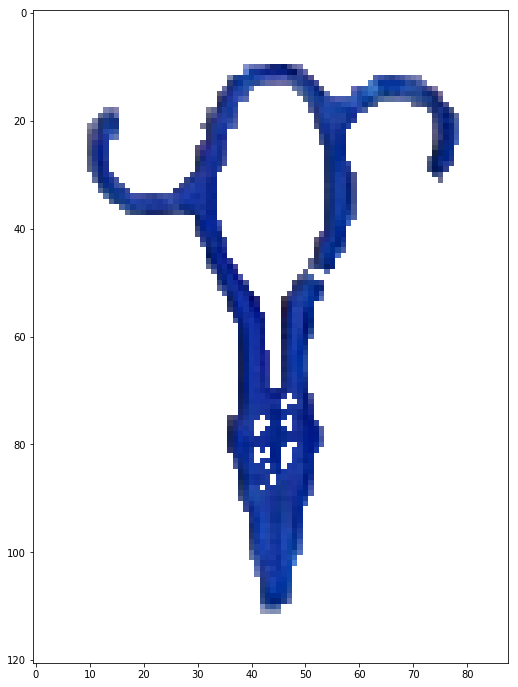

In [10]:
bbox = ann_info['bbox']  
img_crop, corner = cropBBox(np.concatenate([img, mask], axis=2), 
                            bbox)
img_mask = img_crop[:,:,:3] * img_crop[:,:,3:] + 255*(1-img_crop[:,:,3:])
imshowCV(img_mask, axis=True)

In [11]:
model = gen_pose_net('alexnet','sigmoid', output_dim = 1,
                     pretrained = True, siamese_features = False)
load_state_dict(model, weight_file)
model.eval()
if torch.cuda.is_available():
    model.cuda()

pose_estimator = PoseGridEstimator(render_folder, model)

In [12]:
quats, mode_idxs = pose_estimator.getPose(img_mask)
verts = pose_estimator.grid_vertices
renders = pose_estimator.grid_renders[mode_idxs]
quat = to_np(verts[mode_idxs])[0]

In [13]:
print(mode_idxs)

tensor([700])


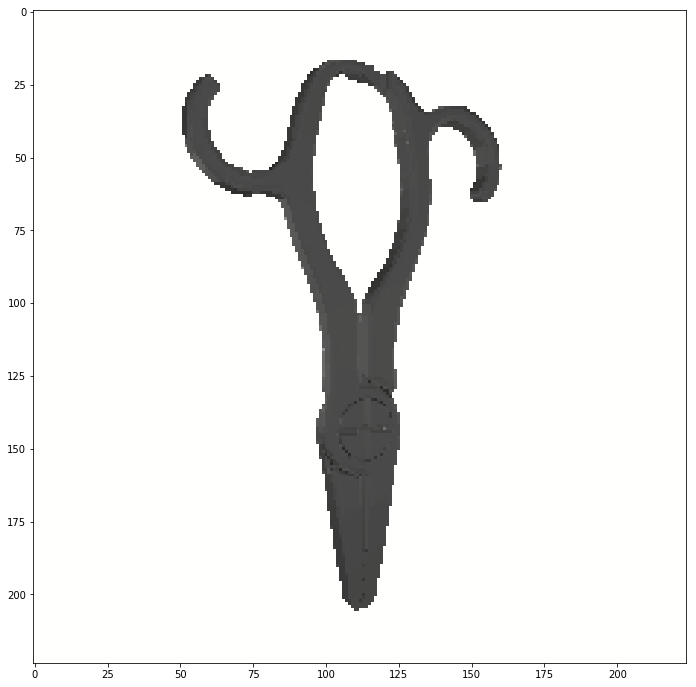

In [14]:
template = unprocessImages(renders)[0].astype(np.uint8)
imshowCV(template, axis=True)

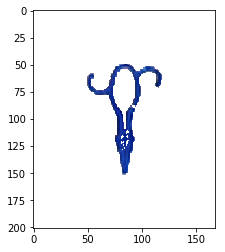

In [11]:
wide_crop, corner = cropBBox(np.concatenate([img, mask], axis=2), 
                             bbox, boarder_width = max(bbox[2:])//2)
wide_masked = wide_crop[:,:,:3] * wide_crop[:,:,3:] + 255*(1-wide_crop[:,:,3:])

imshowCV(wide_masked, axis=True)

In [12]:
t, t_box = computeT(wide_masked, template, f = f, p = p, bbox_corner=corner)
print(t)

[ 0.1076044  -0.00914286  0.80223961]


In [15]:
corner

(351, 167)

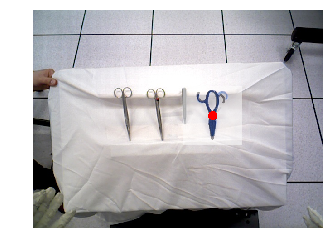

In [15]:
disp_img = img.copy()
y, x, wt, ht = t_box
template_resized = cv2.resize(template, (ht, wt))
y0, x0 = (y - int(np.floor(ht/2)), int(x - np.floor(wt/2)))
y1, x1 = (y + int(np.ceil( ht/2)), int(x + np.ceil( wt/2)))
disp_img[x0:x1, y0:y1] = 0.5 * disp_img[x0:x1, y0:y1] + 0.5*template_resized

cv2.circle(disp_img, (y,x), 10, (0,0,255), -1)
#cv2.rectangle(disp_img, max_loc, (max_loc[0] + ht, max_loc[1] + wt), (255,0,0))
imshowCV(disp_img)

## Only run if you have blender install as a python model

In [16]:
from model_renderer.pose_renderer import BpyRenderer
from generic_pose.datasets.ycb_dataset import ycbRenderTransform
from generic_pose.utils import to_np
from quat_math import quaternion_matrix, euler_matrix

In [17]:
renderer = BpyRenderer(transform_func = ycbRenderTransform)
renderer.loadModel(object_model, emit = 0.5)
#renderer.setCameraMatrix(fx = f, fy = f, px = p[0], py = p[1], 
#                         w = img.shape[1], h = img.shape[0])
h, w = img.shape[:2]
px, py = p

#renderer.bpy.data.scenes['Scene'].unit_settings.system = 'METRIC'
w_s = renderer.bpy.data.cameras['Camera'].sensor_width
f_mm = f/w*w_s
renderer.cam_obj.data.lens = f_mm
renderer.bpy.context.scene.render.resolution_x = w
renderer.bpy.context.scene.render.resolution_y = h
renderer.bpy.context.scene.render.resolution_percentage = 100


renderer.cam_obj.data.shift_x = (w/2 - px)/w
renderer.cam_obj.data.shift_y = (h/2 - py)/h

(  0.0002 sec |   0.0002 sec) Importing OBJ '/home/bokorn/data/surgical/models/hemostat/hemostat_black.obj'...
  (  0.0009 sec |   0.0007 sec) Parsing OBJ file...
    (  0.1124 sec |   0.1115 sec) Done, loading materials and images...
    (  0.1129 sec |   0.1119 sec) Done, building geometries (verts:2597 faces:5192 materials: 1 smoothgroups:0) ...
    (  0.1331 sec |   0.1321 sec) Done.
  (  0.1333 sec |   0.1330 sec) Finished importing: '/home/bokorn/data/surgical/models/hemostat/hemostat_black.obj'
Progress: 100.00%



Rotation: [ 0.         0.2664047  0.        -0.9638613]
Translation: [ 0.1076044  -0.00914286  0.80223961]
[[ 8.58057089e-01  5.13554312e-01 -3.14461322e-17  1.07604396e-01]
 [ 0.00000000e+00  6.12323400e-17  1.00000000e+00 -9.14285714e-03]
 [ 5.13554312e-01 -8.58057089e-01  5.25408434e-17  8.02239612e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


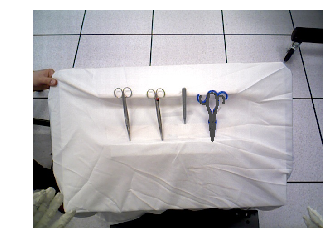

In [18]:
#f_t = 35/1000
#f_i = f / 1000
#tz = template_dist * diag_t/diag * f/f_t
#ty = tz / f * (y - p[0])
#tx = tz / f * (x - p[1])

#t = [ty, tx, tz]

#quat = to_np(quats[0])

print('Rotation:', quat)
print('Translation:', t)

mat = quaternion_matrix(quat)
ycb_mat = euler_matrix(-np.pi/2,0,0)
mat = mat.dot(ycb_mat)
mat[:3,3] = t
#mat[:3,3] = [0.0,0,1.23]
#mat[:3,3] = [ty, -tx, tz]
print(mat)

render_img = renderer.renderTrans(mat)
render_mask = render_img[:,:,3:]/255.0

disp_img = img * (1-render_mask) +  render_img[:,:,:3]
disp_img = disp_img.astype(np.uint8)
#imshowCV(render_img)
#imshowCV(img)

imshowCV(disp_img)